In [149]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, datetime, timedelta
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import random
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
from scipy.stats import norm
from sklearn.preprocessing import Normalizer,StandardScaler, LabelEncoder
from tensorflow_addons.losses import pinball_loss
from sklearn.metrics import mean_pinball_loss
from scipy import stats
import math

In [150]:
quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]
horizons = [36, 48 ,60, 72, 84]

# Read and preprocess data

In [168]:
wind_data = pd.read_feather("data/berlin_data/historic_data/icon_eps_wind_10m.feather")
pressure_data = pd.read_feather("data/berlin_data/historic_data/icon_eps_mslp.feather")
pressure_data.rename({"ens_mean":"mean_pressure"}, axis = 1, inplace = True)
cloud_data = pd.read_feather("data/berlin_data/historic_data/icon_eps_clct.feather")
cloud_data.rename({"ens_mean":"cloud_coverage"}, axis = 1, inplace = True)

data = wind_data.merge(pressure_data[["init_tm","fcst_hour","mean_pressure"]], on = ["init_tm","fcst_hour"], how = "left")
data = data.merge(cloud_data[["init_tm","fcst_hour","cloud_coverage"]], on = ["init_tm","fcst_hour"], how = "left")
data.dropna(inplace=True)
data.head()

,init_tm,met_var,location,fcst_hour,obs_tm,obs,ens_1,ens_2,ens_3,ens_4,...,ens_35,ens_36,ens_37,ens_38,ens_39,ens_40,ens_mean,ens_var,mean_pressure,cloud_coverage
65,2018-12-19 00:00:00+00:00,wind_10m,Berlin,0.0,2018-12-19 00:00:00+00:00,12.60,9.69,9.60,9.85,9.80,...,9.76,10.53,11.33,9.40,9.62,9.97,9.71750,1.179127,1022.41475,3.26025
66,2018-12-19 00:00:00+00:00,wind_10m,Berlin,1.0,2018-12-19 01:00:00+00:00,12.60,10.97,10.49,10.26,10.12,...,10.34,11.43,11.85,10.08,10.76,9.39,10.29675,1.028694,1021.70900,0.58050
67,2018-12-19 00:00:00+00:00,wind_10m,Berlin,2.0,2018-12-19 02:00:00+00:00,12.24,11.76,11.47,10.54,10.51,...,12.19,11.90,12.27,10.36,11.58,9.67,10.99725,0.896077,1020.92025,0.96325
68,2018-12-19 00:00:00+00:00,wind_10m,Berlin,3.0,2018-12-19 03:00:00+00:00,11.52,12.16,12.04,10.95,11.47,...,12.41,12.23,12.78,10.41,11.60,10.23,11.40975,0.622141,1020.62650,12.33875
69,2018-12-19 00:00:00+00:00,wind_10m,Berlin,4.0,2018-12-19 04:00:00+00:00,10.08,12.57,12.79,11.21,12.36,...,13.00,12.91,13.52,11.14,12.16,11.34,12.02400,0.558978,1020.63250,32.37400


## Create positional encoding

In [169]:
pos_enc = pd.DataFrame(index=pd.DatetimeIndex(data["obs_tm"]))
pos_enc["Dayofyear"] = pos_enc.index.dayofyear
pos_enc["n_days"] = 365
pos_enc.loc[pos_enc.index.year==2020,"n_days"] = 366
#Calculate actual positional encoding
cos_encoding = np.cos(2*math.pi*pos_enc["Dayofyear"]/pos_enc["n_days"])
data["pos_enc_1"] = cos_encoding.to_numpy()

## Train, val, test split

In [170]:
train_val_dataframe, test_dataframe = train_test_split(data, test_size = 0.2, random_state = 1)
train_dataframe, val_dataframe = train_test_split(data, test_size = 0.2, random_state = 2)

### Normalize

In [171]:
def normalize(dataframe, label_encoder = None,feature_scaler = None, target_scaler = None, learn = False):
    #Drop unused columns
    data = dataframe.copy()
    data.drop(["init_tm", "met_var", "location",  "ens_var", "obs_tm"], axis = 1, inplace = True)
    data = data.to_numpy()
    if learn == True:
        label_encoder = LabelEncoder()
        feature_scaler = StandardScaler()
        target_scaler = StandardScaler()
        #Learn label encoding for horizons
        label = label_encoder.fit_transform(data[:,0])
        #Learn target scaling
        target_scaled = target_scaler.fit_transform(data[:,1].reshape(-1,1))
        #Learn feature scaling
        feature_scaled = feature_scaler.fit_transform(data[:,2:])
        #Append
        data[:,0] = label
        data[:,1] = target_scaled.reshape(-1)
        data[:,2:] = feature_scaled
        
        return data, label_encoder, feature_scaler, target_scaler
    
    else:
        #Learn labels
        label = label_encoder.transform(data[:,0])
        #Scale target
        target_scaled = target_scaler.transform(data[:,1].reshape(-1,1))
        #Scale features
        feature_scaled = feature_scaler.transform(data[:,2:])
        #Append
        data[:,0] = label
        data[:,1] = target_scaled.reshape(-1)
        data[:,2:] = feature_scaled
        
        return data

In [172]:
train_val, label_encoder, feature_scaler, target_scaler = normalize(train_val_dataframe, learn = True)
train= normalize(train_dataframe, label_encoder, feature_scaler, target_scaler)
test = normalize(test_dataframe, label_encoder, feature_scaler, target_scaler)
val = normalize(val_dataframe, label_encoder, feature_scaler, target_scaler)
#Number of encodings
n_encodings = len(np.unique(train[:,0]))

In [173]:
def convert_format(input_data, predict = False):
    #Extract forecast embedding
    horizon_emb = input_data[:,0]
    
    if predict == False:        
        #Extract features
        features = input_data[:,2:]
        # Extract target
        target = np.expand_dims(input_data[:,1],1)
        return [features, horizon_emb], target
    else:
        #Extract features
        features = input_data[:,1:]
        return [features, horizon_emb]

In [174]:
train_data, train_target = convert_format(train)
val_data, val_target = convert_format(val)
test_data, test_target = convert_format(test)

# Create Model

In [294]:
BATCH_SIZE = 1024
EPOCHS = 100
learning_rate = 0.001

In [295]:
class base_model(tf.keras.Model):    
    def __init__(self, n_embeddings = n_encodings):
        super(base_model, self).__init__()
        #Embedding layers
        self.embedding = Embedding(input_dim = n_embeddings, output_dim = 4)
        #Create Dense layers
        self.hidden = Dense(25, activation = "relu")
        self.out = Dense(1, activation = "linear")

    def call(self, input_data):
        #Extract data
        features, horizon_emb = input_data
        #Calculate embedding
        emb = self.embedding(horizon_emb)
        emb = tf.squeeze(emb, axis = 1)
        conc = Concatenate(axis = 1)([features, emb])
        #Calculate output
        output = self.hidden(conc)
        output = self.out(output)

        return output

In [296]:
def train_model(model, quantile, train_data, train_target, validation_data, batch_size, epochs, learning_rate):
    #Define optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    #Early stopping
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5, min_delta = 1e-5)
    #Compile model
    model.compile(optimizer = optimizer, loss = lambda true,pred: pinball_loss(true, pred, tau = quantile))
    model.fit(x = train_data, y = train_target, validation_data = validation_data, epochs = epochs, batch_size = batch_size, callbacks = [callback], shuffle = True, verbose = False)

In [285]:
def create_all_models(train_data, train_target, validation_data, batch_size = BATCH_SIZE, epochs = EPOCHS, learning_rate = learning_rate, quantiles = quantiles):
    models = dict()
    for quantile in quantiles:
        model = base_model()
        train_model(model, quantile, train_data, train_target, validation_data, batch_size, epochs, learning_rate)
        print("Training finished for quantile: {}".format(quantile))
        
        #Fine tuning
        enc_horizons = label_encoder.transform(horizons)
        train_filtering = np.isin(train_data[1], enc_horizons)
        train_data_fine = [train_data[0][train_filtering], train_data[1][train_filtering]]
        train_target_fine = train_target[train_filtering]
        #Val filtering
        val_data, val_target = validation_data
        val_filtering = np.isin(val_data[1], enc_horizons)
        val_data_fine = [val_data[0][val_filtering], val_data[1][val_filtering]]
        val_target_fine = val_target[val_filtering]
        validation_data_fine = (val_data_fine, val_target_fine)
        
        train_model(model, quantile, train_data_fine, train_target_fine, validation_data_fine, 64, epochs, learning_rate/10)
        print("Fine tuning finished for quantile: {}".format(quantile))
        
        
        models[quantile] = model
    return models

In [286]:
trained_models = create_all_models(train_data, train_target, (val_data, val_target))

Epoch 1/100
100/100 [==============================] - 1s 7ms/step - loss: 0.9545 - val_loss: 0.1166
Epoch 2/100
100/100 [==============================] - 0s 4ms/step - loss: 0.0946 - val_loss: 0.0679
Epoch 3/100
100/100 [==============================] - 0s 4ms/step - loss: 0.0625 - val_loss: 0.0518
Epoch 4/100
100/100 [==============================] - 0s 4ms/step - loss: 0.0475 - val_loss: 0.0399
Epoch 5/100
100/100 [==============================] - 0s 4ms/step - loss: 0.0371 - val_loss: 0.0338
Epoch 6/100
100/100 [==============================] - 0s 4ms/step - loss: 0.0330 - val_loss: 0.0323
Epoch 7/100
100/100 [==============================] - 0s 4ms/step - loss: 0.0318 - val_loss: 0.0322
Epoch 8/100
100/100 [==============================] - 0s 4ms/step - loss: 0.0313 - val_loss: 0.0317
Epoch 9/100
100/100 [==============================] - 0s 4ms/step - loss: 0.0308 - val_loss: 0.0321
Epoch 10/100
100/100 [==============================] - 0s 5ms/step - loss: 0.0309 - val_lo

# Predict test data

In [287]:
predictions = dict()
for quantile in quantiles:
    pred = trained_models[quantile].predict(test_data)
    predictions[quantile] = pred

## Evaluate pinball loss on naive prediction

In [288]:
total_loss = 0
naive_pred = np.quantile(test_data[0], quantiles, axis = 1)
for cnt,quantile in enumerate(quantiles):
    loss = mean_pinball_loss(np.squeeze(test_target), naive_pred[cnt], alpha = quantile)
    total_loss += loss
    print("Pinball loss for quantile {} : \t {}".format(quantile,loss))
print("Pinball Loss total: {}".format(total_loss/len(quantiles)))

Pinball loss for quantile 0.025 : 	 0.04554659406151322
Pinball loss for quantile 0.25 : 	 0.19323225464482754
Pinball loss for quantile 0.5 : 	 0.2381648044899716
Pinball loss for quantile 0.75 : 	 0.2031984107232562
Pinball loss for quantile 0.975 : 	 0.06250936134165751
Pinball Loss total: 0.14853028505224522


## Pinball Loss

### All horizons

In [289]:
total_loss = 0
for quantile in quantiles:
    loss = mean_pinball_loss(test_target.reshape(-1), predictions[quantile].reshape(-1), alpha = quantile)
    total_loss += loss
    print("Pinball loss for quantile {} : \t {}".format(quantile,loss))
print("Pinball Loss total: {}".format(total_loss/len(quantiles)))

Pinball loss for quantile 0.025 : 	 0.02951560704592972
Pinball loss for quantile 0.25 : 	 0.1706064775945438
Pinball loss for quantile 0.5 : 	 0.22565051076964263
Pinball loss for quantile 0.75 : 	 0.18718977085625593
Pinball loss for quantile 0.975 : 	 0.03870717303898624
Pinball Loss total: 0.13033390786107169


### Specific horizons

In [290]:
eval_df = test_dataframe[["fcst_hour","obs"]].copy()
eval_df["obs"] = target_scaler.transform(eval_df["obs"].to_numpy().reshape(-1,1))
for quantile in quantiles:
    eval_df[quantile] = predictions[quantile]
eval_df = eval_df[eval_df["fcst_hour"].isin(horizons)]

total_loss = 0
for quantile in quantiles:
    loss = mean_pinball_loss(eval_df["obs"], eval_df[quantile], alpha = quantile)
    total_loss += loss
    print("Pinball loss for quantile {} : \t {}".format(quantile,loss))
print("Pinball Loss total: {}".format(total_loss/len(quantiles)))

Pinball loss for quantile 0.025 : 	 0.0335473487606977
Pinball loss for quantile 0.25 : 	 0.18697708749563635
Pinball loss for quantile 0.5 : 	 0.2405942339604457
Pinball loss for quantile 0.75 : 	 0.19344916103486412
Pinball loss for quantile 0.975 : 	 0.03862675749188059
Pinball Loss total: 0.1386389177487049


## Plausability

### All horizons

In [291]:
for quantile in quantiles:
    q_smaller = (predictions[quantile] > test_target).sum()
    emp_quant = q_smaller / predictions[quantile].size
    print("Quantile met for quantile = {}: \t {} %".format(quantile, np.round(emp_quant,4)*100))

Quantile met for quantile = 0.025: 	 2.4699999999999998 %
Quantile met for quantile = 0.25: 	 25.019999999999996 %
Quantile met for quantile = 0.5: 	 50.39 %
Quantile met for quantile = 0.75: 	 74.71 %
Quantile met for quantile = 0.975: 	 97.16 %


### Specific horizons

In [292]:
for quantile in quantiles:
    q_smaller = (eval_df[quantile] > eval_df["obs"]).sum()
    emp_quant = q_smaller / eval_df[quantile].size
    print("Quantile met for quantile = {}: \t {} %".format(quantile, np.round(emp_quant,4)*100))

Quantile met for quantile = 0.025: 	 2.4 %
Quantile met for quantile = 0.25: 	 24.240000000000002 %
Quantile met for quantile = 0.5: 	 49.84 %
Quantile met for quantile = 0.75: 	 74.71 %
Quantile met for quantile = 0.975: 	 97.49 %


## Visualize predictions

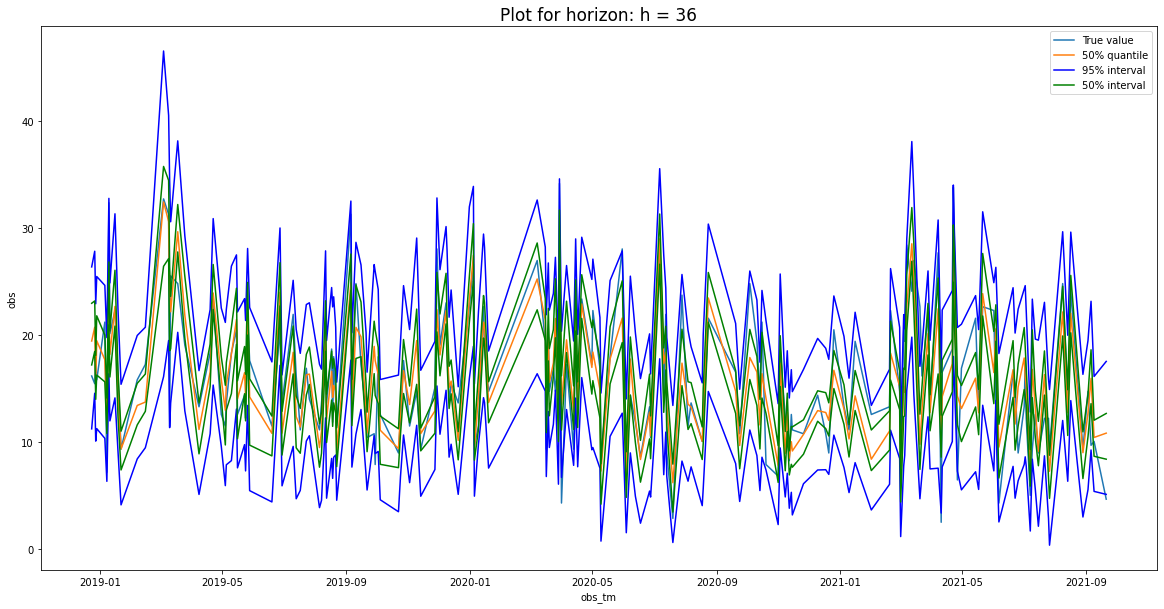

In [293]:
# Create plotting dataframe
data_plot = test_dataframe[["obs_tm","obs","fcst_hour"]].copy()
for cnt, quantile in enumerate(quantiles):
    data_plot["q{}".format(quantile)] = target_scaler.inverse_transform(predictions[quantile]).reshape(-1)

#Extract horizon
h=36
data_plot = data_plot[data_plot["fcst_hour"]==h]

fig, axs = plt.subplots(figsize = (20,10))
sns.lineplot(x = "obs_tm", y = "obs", data = data_plot, label = "True value")
sns.lineplot(x = "obs_tm", y = "q0.5", data = data_plot, label = "50% quantile")
sns.lineplot(x = "obs_tm", y = "q0.025", data = data_plot, color = "blue", label = "95% interval")
sns.lineplot(x = "obs_tm", y = "q0.975", data = data_plot, color = "blue")

sns.lineplot(x = "obs_tm", y = "q0.25", data = data_plot, color = "green", label = "50% interval")
sns.lineplot(x = "obs_tm", y = "q0.75", data = data_plot, color = "green")
axs.set_title("Plot for horizon: h = {}".format(h),size = 17)
axs.legend()

# Predict new data

## Train on complete data without test set

In [20]:
train_data, train_target = convert_format(train_val)
val_data, val_target = convert_format(test)

In [21]:
trained_models = create_all_models(train_data, train_target, (val_data, val_target))

Training finished for quantile: 0.025
Training finished for quantile: 0.25
Training finished for quantile: 0.5
Training finished for quantile: 0.75
Training finished for quantile: 0.975


## Predict new data

In [22]:
current_date = date.today().strftime("%Y%m%d")
path = "data/berlin_data/icon_data/icon-eu-eps_{}00_wind_mean_10m_Berlin.txt".format(current_date)
new_data = pd.read_csv(path.format(current_date.replace("-","")), skiprows = 3, sep = "|").dropna(axis = 1)
new_data.columns = new_data.columns.str.replace(" ", "")
new_data = new_data[new_data["fcst_hour"].isin(horizons)]
#Create positional encoding
date_list = [(date.today()+timedelta(x)) for x in horizons]
new_data["day"] = pd.DatetimeIndex(date_list).dayofyear
new_data["pos_enc_1"] = np.sin(2*math.pi*new_data["day"]/365)
new_data["pos_enc_2"] = np.cos(2*math.pi*new_data["day"]/365)
new_data.drop("day", axis = 1, inplace = True)
# Normalize and get horizons
new_data = new_data[new_data["fcst_hour"].isin(horizons)].to_numpy()
new_data[:,1:] = feature_scaler.transform(new_data[:,1:])
new_data[:,0] = label_encoder.transform(new_data[:,0])

In [23]:
pred_data = convert_format(new_data, predict = True)

In [24]:
#Prepare dataframe
final_prediction = pd.DataFrame(columns = ["forecast_date","target","horizon","q0.025","q0.25","q0.5","q0.75","q0.975"], index = np.arange(0,5))
final_prediction["forecast_date"] = datetime.today().strftime("%Y-%m-%d")
final_prediction["horizon"] = ["{} hour".format(x) for x in horizons]
final_prediction["target"] = "wind"

In [25]:
for cnt, quantile in enumerate(quantiles):
    #Get prediction
    prediction = trained_models[cnt].predict(pred_data)
    #Retransform
    final_pred = target_scaler.inverse_transform(prediction)
    final_prediction.loc[:,"q{}".format(quantile)] = final_pred

In [26]:
final_prediction

,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2021-12-01,wind,36 hour,10.989122,18.893234,20.929962,23.678852,32.472843
1,2021-12-01,wind,48 hour,6.684490,9.795548,12.049109,17.205172,20.461037
2,2021-12-01,wind,60 hour,10.976442,14.990401,18.094439,21.712988,26.555796
3,2021-12-01,wind,72 hour,7.900277,13.945244,16.223789,19.912350,25.765842
4,2021-12-01,wind,84 hour,4.620611,12.947124,13.510809,16.888138,29.329157


In [27]:
new_data = pd.read_csv(path.format(current_date.replace("-","")), skiprows = 3, sep = "|").dropna(axis = 1)
new_data.columns = new_data.columns.str.replace(" ", "")
new_data[new_data["fcst_hour"].isin(horizons)].quantile(0.5, axis = 1)

36    17.14
48    10.83
52    15.44
56    13.86
58    12.67
Name: 0.5, dtype: float64

In [28]:
final_prediction.to_pickle("../evaluation/predictions/single/{}_{}".format("wind", date.today().strftime("%Y-%m-%d")))

# Old code

## Check relationship with time

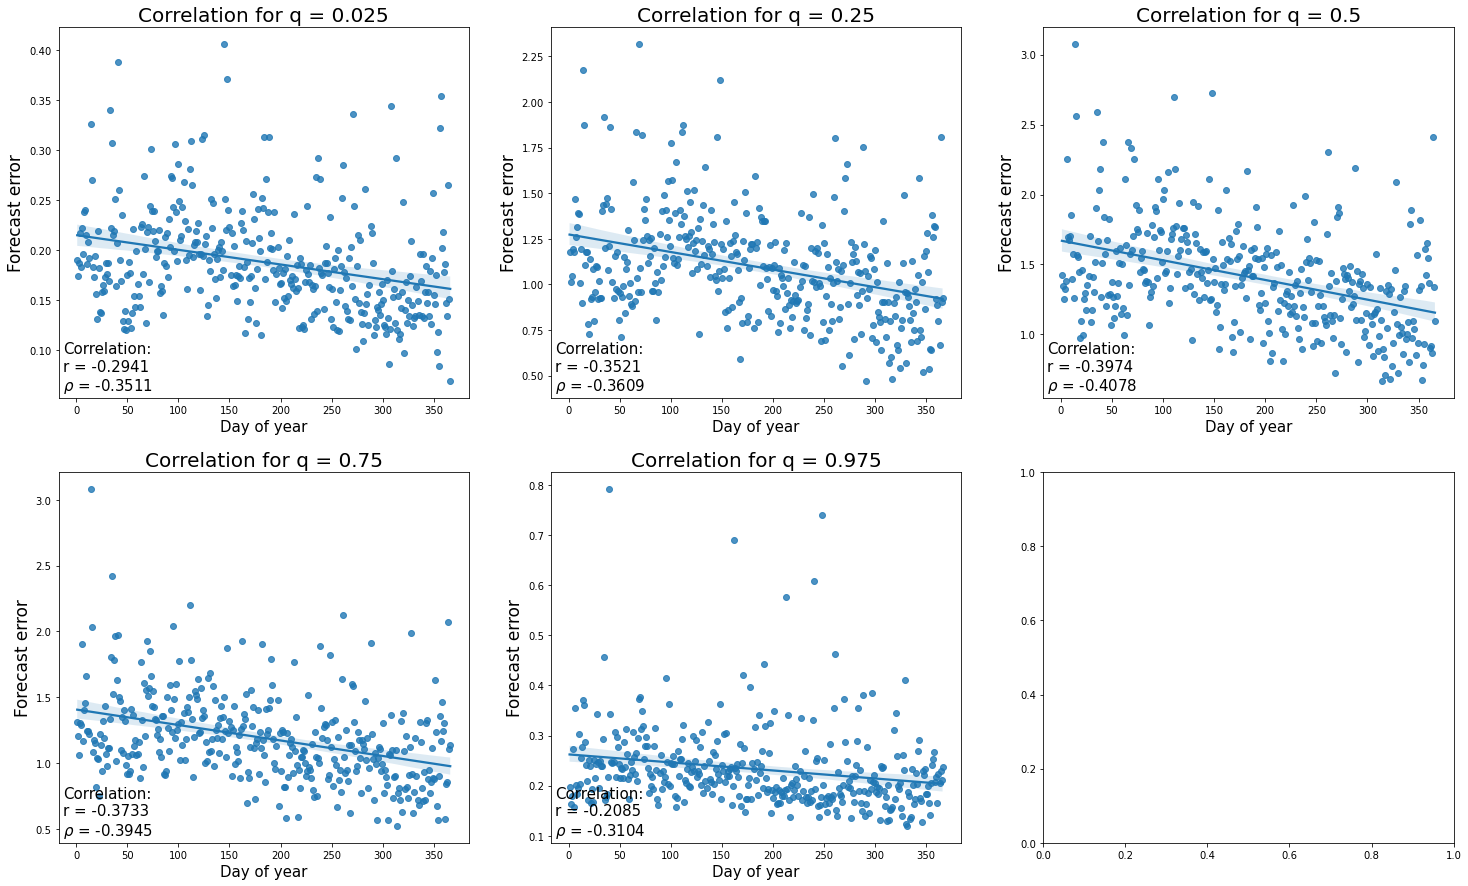

In [19]:
fig, ax = plt.subplots(2,3,figsize=(25,15))
ax = ax.ravel()
for cnt, quantile in enumerate(quantiles):
    #Renormalize and calculate forecast error
    error = mean_pinball_loss(test_dataframe["obs"].to_numpy().reshape(1,-1), target_scaler.inverse_transform(predictions[cnt]).reshape(1,-1), multioutput="raw_values", alpha=quantile)
    test_dataframe["Forecast_error"] = error
    test_dataframe["day"] = pd.DatetimeIndex(test_dataframe["obs_tm"]).dayofyear
    plot = test_dataframe.groupby("day").mean().reset_index()

    sns.regplot(x = "day", y = "Forecast_error", data=plot, ax = ax[cnt])
    ax[cnt].set_xlabel("Day of year",size = 15)
    ax[cnt].set_ylabel("Forecast error", size = 17)
    ax[cnt].set_title("Correlation for q = {}".format(quantile),size = 20)
    r = stats.pearsonr(plot["day"], plot["Forecast_error"])[0]
    rho = stats.spearmanr(plot["day"], plot["Forecast_error"])[0]
    ax[cnt].annotate('Correlation:\nr = {:.4f}\n'.format(r)+r'$\rho$ = {:.4f}'.format(rho),xy = (.01,.02), xycoords=ax[cnt].transAxes, size = 15)
    
#plt.savefig("wind_time_correlation_corrected_plot.pdf", dpi=300)